In this notebook, we will continue the work from last notebook (CNN_an_small_dataset). The purpose is to speed up the training by using pretrained network. Since the matter of computation, a pretrained network, especially a large-scale image-classification network, can saving a lot of time. If the pretrained network is large enough, which menas the dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world. Hence its features can prove useful for many different computer- vision problems, even though these new problems may involve completely different classes than those of the original task.

We will use VGG16 architeture and ImageNet dataset.

The methods to use a pretrained network are `feature extraction` and `fine-tuning`.

In [13]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import matplotlib.pyplot as plt
import os, shutil
import cv2
import numpy as np

In [14]:
conv_base = VGG16(weights = 'imagenet', #weight from imagenet
                  include_top = False, # whether including the dense layers of  
                  input_shape = (150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature extraction

There are two optional methods for feature extraction.
1. Running the convolutional base over our dataset. 
   ==> data augmentation is forbbiden
2. Adding dense layers after convolutional base (on top).
   ==> computation-consuming.

Here, we use the first one.

### Feature extracting

In [15]:
base_dir = '/Users/zhiruitang/Desktop/Deep_Learning/Jupyter_Code_DL/Convolution_neural_networks/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)*batch_size] = features_batch
        labels[i * batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)

#flatten data before feeding into dense layers
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) 
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512)) 
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### define model from trained network

In [16]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512)) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, #trained 
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    verbose=2)


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 3s - loss: 0.6094 - acc: 0.6610 - val_loss: 0.4370 - val_acc: 0.8480
Epoch 2/30
 - 2s - loss: 0.4219 - acc: 0.8130 - val_loss: 0.3587 - val_acc: 0.8740
Epoch 3/30
 - 2s - loss: 0.3492 - acc: 0.8655 - val_loss: 0.3216 - val_acc: 0.8790
Epoch 4/30
 - 2s - loss: 0.3128 - acc: 0.8700 - val_loss: 0.3051 - val_acc: 0.8760
Epoch 5/30
 - 2s - loss: 0.2809 - acc: 0.8855 - val_loss: 0.2862 - val_acc: 0.8900
Epoch 6/30
 - 2s - loss: 0.2657 - acc: 0.8945 - val_loss: 0.2729 - val_acc: 0.8900
Epoch 7/30
 - 2s - loss: 0.2459 - acc: 0.9035 - val_loss: 0.2685 - val_acc: 0.8900
Epoch 8/30
 - 2s - loss: 0.2280 - acc: 0.9150 - val_loss: 0.2584 - val_acc: 0.8960
Epoch 9/30
 - 2s - loss: 0.2164 - acc: 0.9210 - val_loss: 0.2561 - val_acc: 0.8940
Epoch 10/30
 - 3s - loss: 0.2038 - acc: 0.9195 - val_loss: 0.2519 - val_acc: 0.9020
Epoch 11/30
 - 2s - loss: 0.1909 - acc: 0.9365 - val_loss: 0.2485 - val_acc: 0.8970
Epoch 12/30
 - 2s - loss: 0.1768 - ac

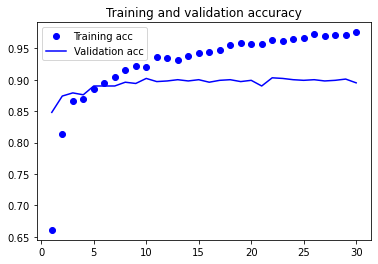

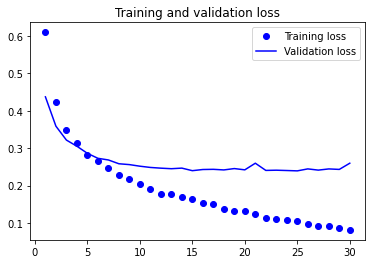

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [18]:
#To be continue